# Integrating human and macaque caudate snATAC-seq

Notes on linked peaks notes: 
- human peak w/ macaque ortholog intersecting human ortholog of macaque peak
- call ties w/ multiple peak matches using nearest summits
- count matrix comes from linked peaks 1-1 in human and macaque 

Notes on integration:
- perform integration with about same number of cells in each group
- here selected representative human and macaque subject
- predefine the features during anchor finding step

In [1]:
PROJDIR=file.path('../../../data/raw_data/primate_peak_orthologs')

#######################################
### set up libraries and functions ####
ss <- function(x, pattern, slot = 1, ...) { 
  sapply(strsplit(x = x, split = pattern, ...), '[', slot) }
options(stringsAsFactors = F, repr.plot.width=14, repr.plot.height=6)
suppressMessages(library(Signac)); suppressMessages(library(Seurat))
suppressMessages(library(harmony))

source('../hal_scripts/narrowPeakFunctions.R')

In [2]:
# # set up future for parallelization
library(future)
library(future.apply)
plan("sequential")
options(future.globals.maxSize = 180 * 1024^3)

# 1) visualize unintegrated species clusters

In [3]:
## load the seurat object
saveRDS_fn = file.path(PROJDIR, 'rdas', 'linkOrthologMatrixSeurat.rds')
obj_seurat = readRDS(file = saveRDS_fn)

In [4]:
##  TF-IDF, SVD, and UMAP already performed on 'peaks' matrix
obj_seurat
obj_seurat@meta.data$log10nFrags = log10(obj_seurat@meta.data$nFrags)

An object of class Seurat 
136023 features across 32107 samples within 1 assay 
Active assay: peaks (136023 features, 136023 variable features)
 2 dimensional reductions calculated: lsi, umap

Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"


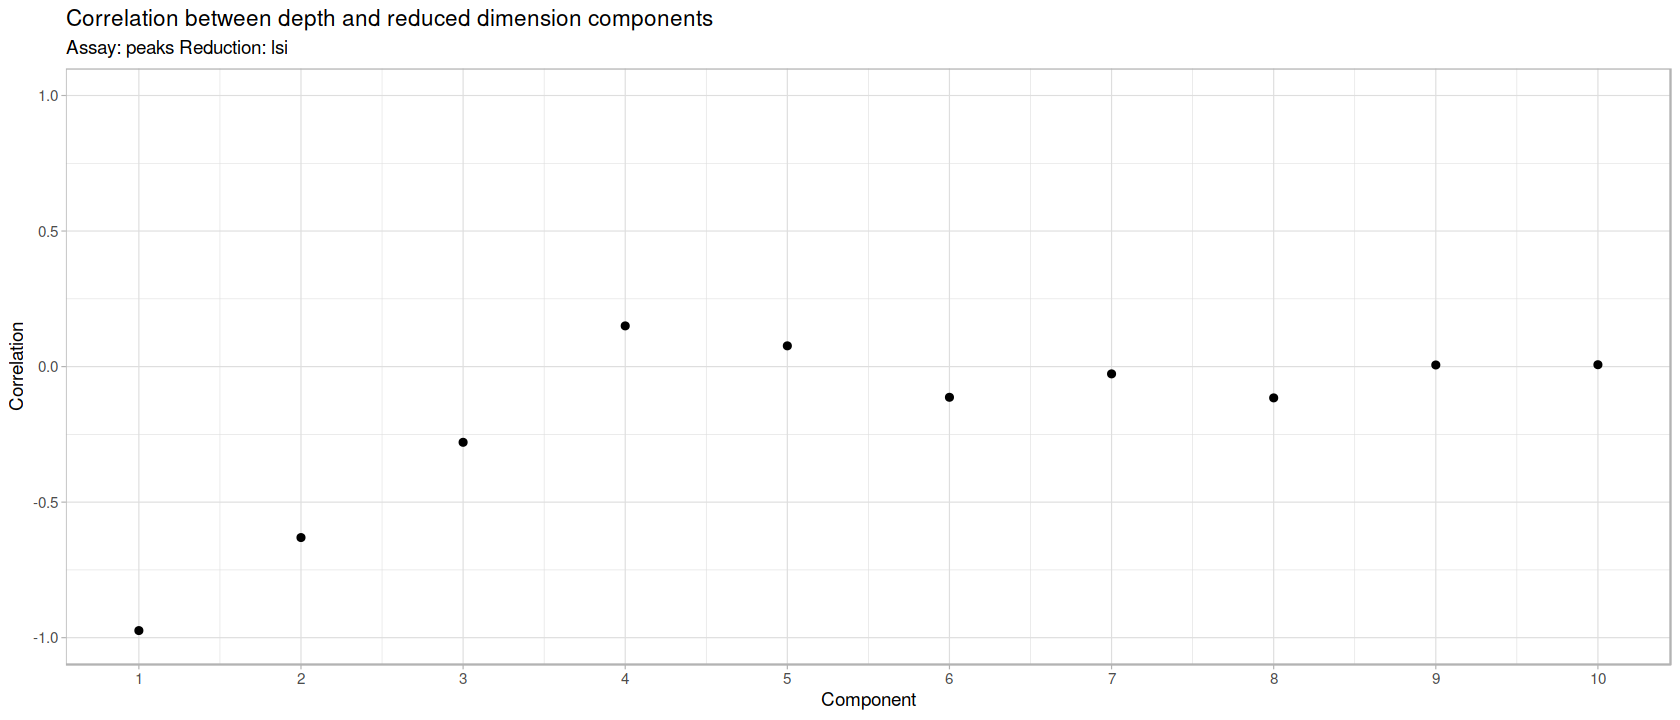

In [5]:
DepthCor(obj_seurat) # drop the first PC, correlated with number fragments

# recompute UMAP b/c first and second PC correlate w/ depth
obj_seurat <- RunUMAP(object = obj_seurat, verbose = FALSE, reduction = 'lsi', dims = 3:30)

In [6]:
### subset to just humans ###
cells = WhichCells(obj_seurat, expression = Sample %in% c("09_1589.CAUD", "14_1018.CAUD", "06_0615.CAUD"))
obj_seurat = subset(obj_seurat, cells = cells)

## show cells per Species
table(obj_seurat@meta.data$Sample)

## show cell clusters per sample
table(obj_seurat@meta.data$Clusters2, obj_seurat@meta.data$Sample)


06_0615.CAUD 09_1589.CAUD 14_1018.CAUD 
       10199         8672         7443 

             
              06_0615.CAUD 09_1589.CAUD 14_1018.CAUD
  Astro                436          391          417
  Interneuron          281          210          133
  Microglia            806          634          278
  MSN_D1              1191         1315          650
  MSN_D2              1240         1497          746
  MSN_UNK1             378          189           11
  MSN_UNK2             389          126           16
  Mural                220          164           68
  Oligo               4651         3747         4952
  OPC                  582          367          160
  VLMC                  25           32           12

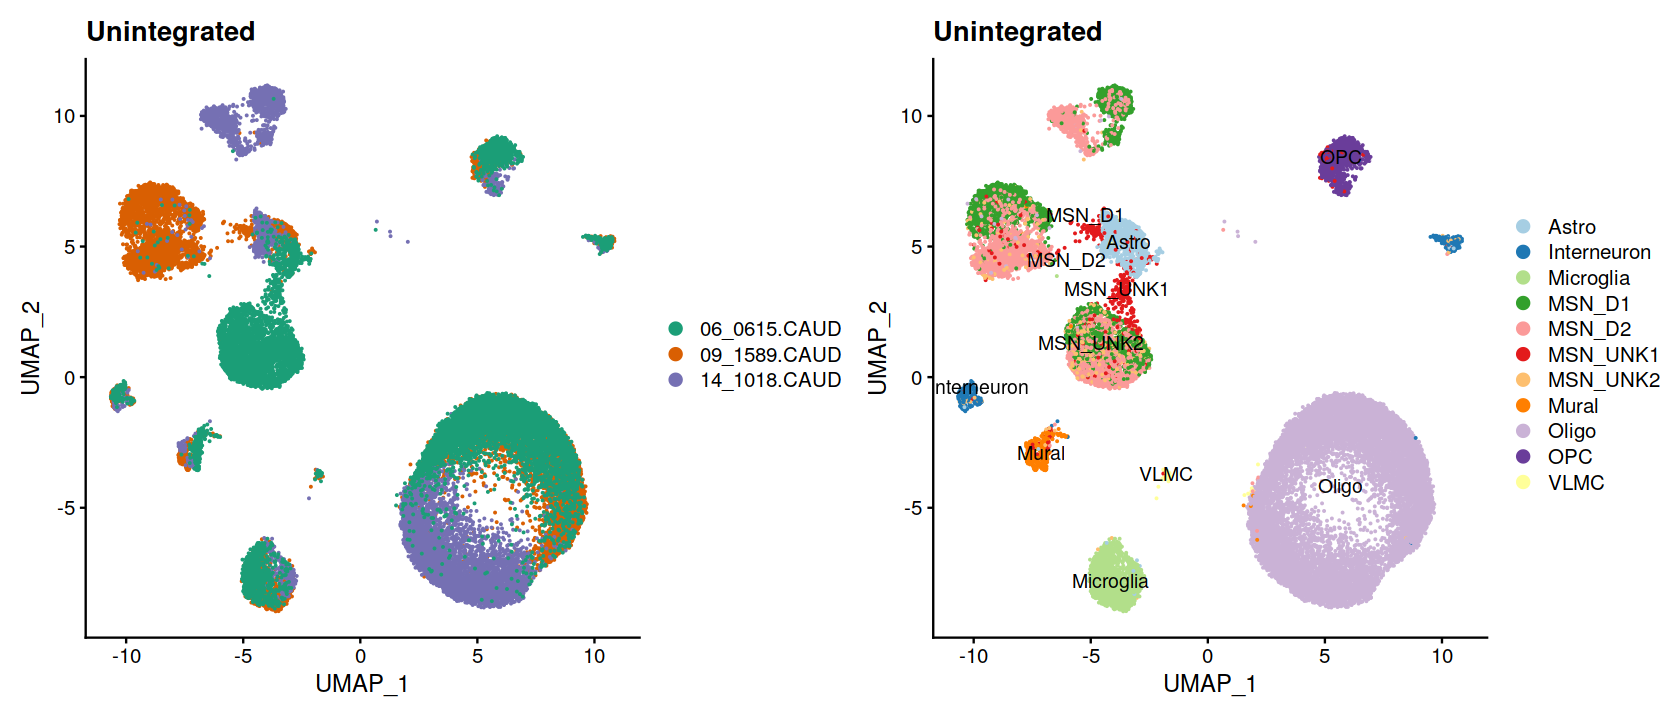

In [7]:
p_unintegrated_species = 
    DimPlot(object = obj_seurat, label = FALSE, group.by = 'Sample', cols = 'Dark2') + 
    ggplot2::ggtitle("Unintegrated")

p_unintegrated_clusters2 = 
    DimPlot(object = obj_seurat, label = TRUE, group.by = 'Clusters2', cols = 'Paired') + 
    ggplot2::ggtitle("Unintegrated")

p_unintegrated_species + p_unintegrated_clusters2

# 2) integration with Seurat CCA

In [8]:
## split seurat object up by species
obj_seurat.list = SplitObject(obj_seurat, split.by = 'Sample')
print(names(obj_seurat.list))
obj_seurat.list = lapply(obj_seurat.list, function(x){
  x <- RunTFIDF(x, verbose = FALSE)
#   x <- FindTopFeatures(x, min.cutoff = 'q5')
  x <- RunSVD(x, verbose = FALSE)
})

# features <- SelectIntegrationFeatures(object.list = obj_seurat.list, nfeatures = 10000)
features <- rownames(obj_seurat)

[1] "09_1589.CAUD" "14_1018.CAUD" "06_0615.CAUD"


In [9]:
# using 14_1018.CAUD as reference
ref = which(names(obj_seurat.list) =="14_1018.CAUD") 

# find integration anchors between species, using all features
anchors <- FindIntegrationAnchors(
        object.list = obj_seurat.list, reduction = 'cca', anchor.features = features,
        reference = c(ref), k.filter = NA, assay = rep('peaks', length(obj_seurat.list)))
gc()

Scaling features for provided objects

Finding anchors between all query and reference datasets

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 20659 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 22622 anchors



,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,11221653,599.4,17062155,911.3,17062155,911.3
Vcells,4012076249,30609.8,12352860281,94244.9,15441064956,117806.0


In [10]:
# integrate data and create a new merged object
integrated <- IntegrateData(anchors, dims = 2:30, preserve.order = TRUE)

# we now have a "corrected" TF-IDF matrix, and can run LSI again on this corrected matrix
integrated <- RunSVD(integrated, n = 30, reduction.name = 'integratedLSI', verbose = FALSE)
integrated <- RunUMAP(integrated, dims = 2:30, reduction = 'integratedLSI', verbose = FALSE)

Integrating dataset 1 with reference dataset

Finding integration vectors

Finding integration vector weights

Integrating data

Integrating dataset 3 with reference dataset

Finding integration vectors

Finding integration vector weights

Integrating data

Warning message:
"Adding a command log without an assay associated with it"


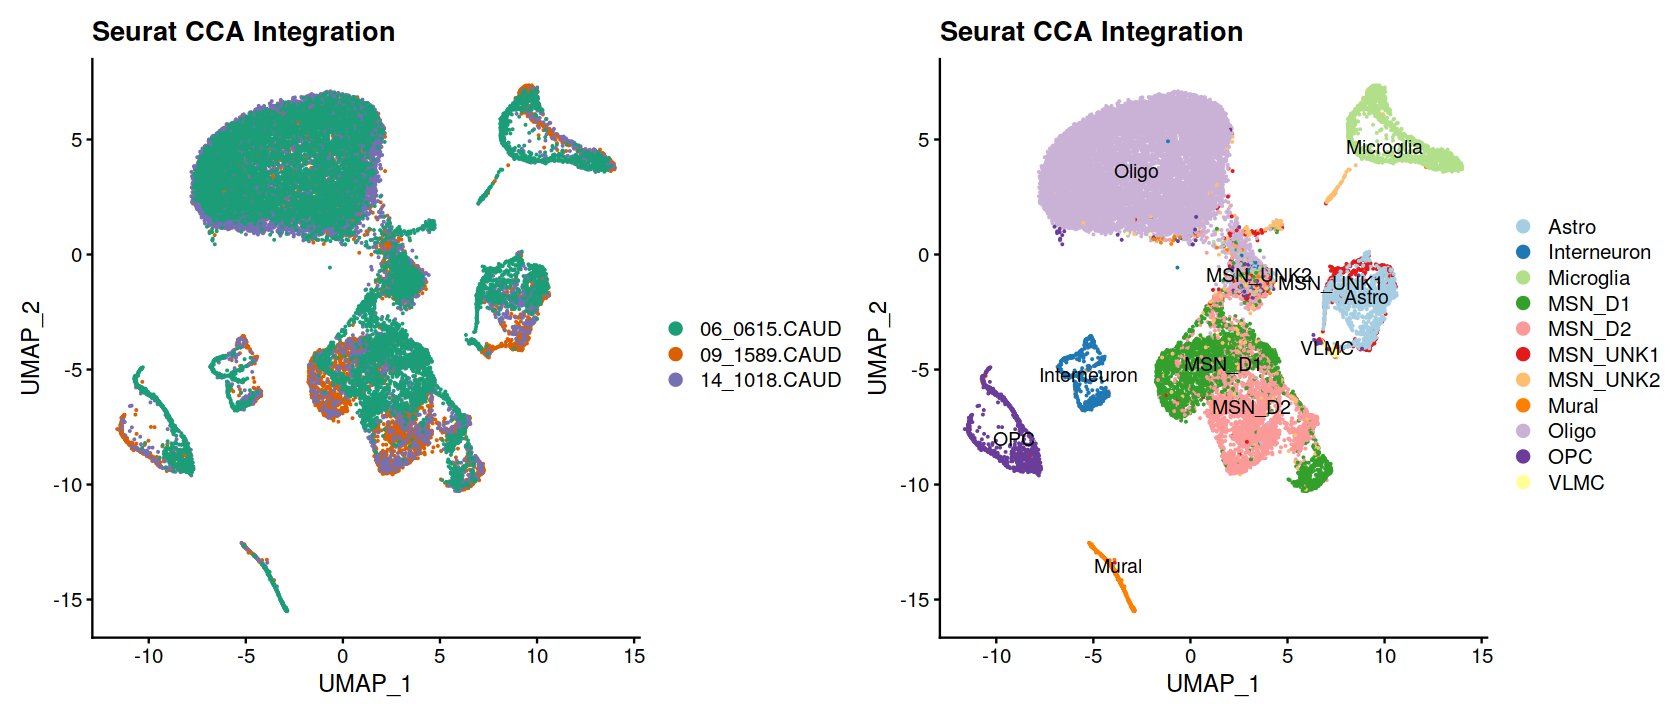

In [11]:
# plot embeddings
p_seuratIntegration_species = 
    DimPlot(object = integrated, label = FALSE, group.by = 'Sample', cols = 'Dark2') +
    ggplot2::ggtitle('Seurat CCA Integration')

p_seuratIntegration_clusters2 = 
    DimPlot(object = integrated, label = TRUE, group.by = 'Clusters2', cols = 'Paired') +
    ggplot2::ggtitle('Seurat CCA Integration')

p_seuratIntegration_species + p_seuratIntegration_clusters2

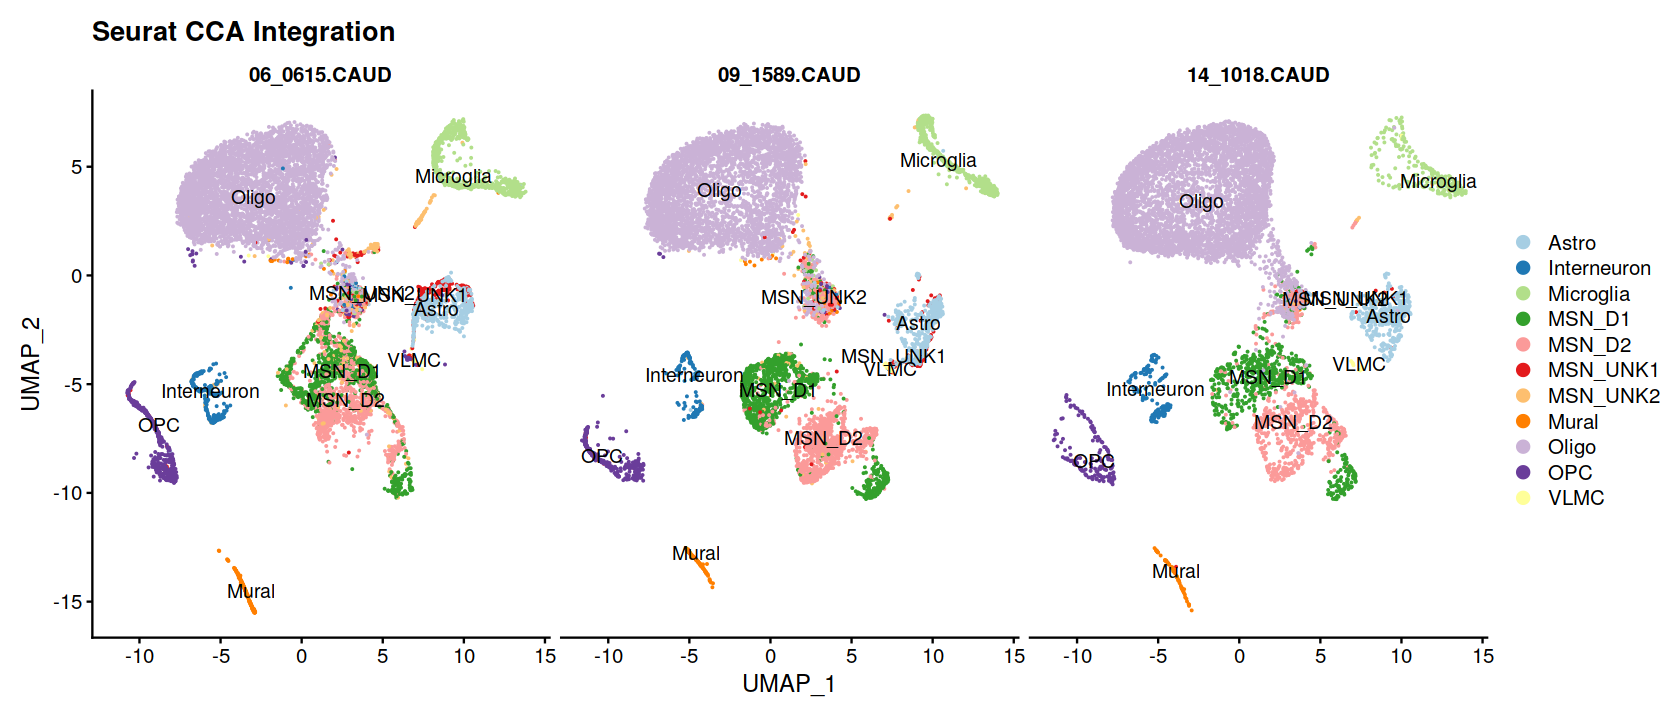

In [12]:
DimPlot(object = integrated, label = TRUE, group.by = 'Clusters2', cols = 'Paired',split.by = 'Sample') +
    ggplot2::ggtitle('Seurat CCA Integration')

In [13]:
rm(obj_seurat.list, obj_seurat, anchors); gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,11265498,601.7,17062155,911.3,17062155,911.3
Vcells,6056505861,46207.5,18738031060,142959.9,23336686941,178044.8


In [14]:
integrated
object.size(integrated) / 1024^3

An object of class Seurat 
272046 features across 26314 samples within 2 assays 
Active assay: integrated (136023 features, 136023 variable features)
 1 other assay present: peaks
 2 dimensional reductions calculated: integratedLSI, umap

43.6 bytes

In [15]:
integrated.trim = DietSeurat(
    integrated, counts = TRUE, data = TRUE, scale.data = FALSE, 
    assays = c('peaks', 'integrated'), dimreducs = c('integratedLSI','umap'))

object.size(integrated.trim) / 1024^3

16.9 bytes

In [16]:
## save the seurat object
integratedRDS_fn = file.path(PROJDIR,'rdas','linkOrthologSeuratCCAHumanOnly.rds')
saveRDS(integrated.trim, file = integratedRDS_fn)

In [17]:
rm(integrated); gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,11266462,601.7,17062155,911.3,17062155,911.3
Vcells,6056507841,46207.5,18738031060,142959.9,23336686941,178044.8
